# <span style="color:#bce35b;font-size:35px"><b>Project</b></span>
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<span style="color:#8c8c8c">Patrick Weatherford</span><br>
<span style="color:#8c8c8c">DSC 540 - Data Preparation</span>

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

***

<br>

<span style="font-size:18px"><b>Overview</b>:

For this project, I'll be obtaining, joining, and visualizing data by country/year for cancer mortality, sun duration time, and observed solar cycle information. 

***

<br>

<span style="font-size:18px"><b>Import Libraries</b>:

In [134]:
import keyring
import os

## manually set environment variables for kaggle api to download straight from Python to current directory
os.environ["KAGGLE_USERNAME"] = "hakunapatata"
os.environ["KAGGLE_KEY"] = keyring.get_password(
    service_name="kaggle_api", username=os.environ["KAGGLE_USERNAME"]
)

import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import kaggle
from bs4 import BeautifulSoup as BS
import requests
from http.client import responses
from collections import deque

## matplotlib default settings
plt.style.use("dark_background")
mpl.rcParams.update({"lines.linewidth": 3})
mpl.rcParams.update({"axes.labelsize": 14})
mpl.rcParams.update({"axes.titlesize": 16})
mpl.rcParams.update({"axes.titleweight": "bold"})
mpl.rcParams.update({"figure.autolayout": True})
mpl.rcParams.update(
    {"axes.grid": True, "grid.color": "#424242", "grid.linestyle": "--"}
)


<br>

***

# <span style="color:#bce35b">Data Sets</span>

<!--  Copy/Past below !! Do not overwrite!!  -->
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<!-- <span style="color:#8c8c8c">Patrick Weatherford</span> -->

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

<span style="font-size:18px"><b>Overview</b>:

For this project, there are 3 different datasets required which must come from different sources. One source via a flat file download, another source from web scraping, and a final source from an API call. The final dataset must have at least 1000 observations. 
    
After reviewing datasets from multiple different sources, I ran across a dataset which has cancer death totals by country/city/year. One of the columns had total deaths from malignant skin melanoma which caught my attention due to multiple members of my family passing away from this type of cancer and the fact that as of this writing, I’m severely sunburned from a recent fishing expedition. From here, I began to hypothesize that peak solar cycles and sun duration by country may have an effect on the total amount of deaths due to malignant skin melanoma. Who knows, maybe it has an effect on all types of cancer. At this point I searched and found 2 more datasets which I could use to join onto the cancer mortality dataset. One found on Wikipedia which had sun duration times by country/city/month and the other found on NOAA (National Oceanic and Atmospheric Administration) which had historical solar cycle information. 
    
If strong correlation was found with cancer deaths, high solar durations, and periods of solar maximums, more awareness could be raised to warn the public and potentially reduce the number of cancer deaths. 
Depending on the dataset, I’ll either be joining based on the country name or year. One potential challenge I see when joining the data by country would be the fact that each data source may have different spellings for each country or may incorporate different capitalizations which will need to be handled.  


## <span style="color:#ae8bd5">Flat File</span>

<!--  Copy/Past below !! Do not overwrite!!  -->
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<!-- <span style="color:#8c8c8c">Patrick Weatherford</span> -->

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

This dataset contains total cancer deaths by country/year and cancer type.<br>
[https://www.kaggle.com/datasets/bahadirumutiscimen/cancer-death-rates-in-the-world-19902019?select=total-cancer-deaths-by-type.csv](https://www.kaggle.com/datasets/bahadirumutiscimen/cancer-death-rates-in-the-world-19902019?select=total-cancer-deaths-by-type.csv)

In [107]:
dataset = "bahadirumutiscimen/cancer-death-rates-in-the-world-19902019"
file_name = "total-cancer-deaths-by-type.csv"

kaggle.api.dataset_download_file(dataset=dataset, file_name=file_name, quiet=True)


cancer_df = pd.read_csv(file_name + ".zip")


In [108]:
cancer_df


,Entity,Code,Year,Deaths - Liver cancer - Sex: Both - Age: All Ages (Number),Deaths - Kidney cancer - Sex: Both - Age: All Ages (Number),Deaths - Lip and oral cavity cancer - Sex: Both - Age: All Ages (Number),"Deaths - Tracheal, bronchus, and lung cancer - Sex: Both - Age: All Ages (Number)",Deaths - Larynx cancer - Sex: Both - Age: All Ages (Number),Deaths - Gallbladder and biliary tract cancer - Sex: Both - Age: All Ages (Number),Deaths - Malignant skin melanoma - Sex: Both - Age: All Ages (Number),...,Deaths - Brain and central nervous system cancer - Sex: Both - Age: All Ages (Number),Deaths - Non-Hodgkin lymphoma - Sex: Both - Age: All Ages (Number),Deaths - Pancreatic cancer - Sex: Both - Age: All Ages (Number),Deaths - Esophageal cancer - Sex: Both - Age: All Ages (Number),Deaths - Testicular cancer - Sex: Both - Age: All Ages (Number),Deaths - Nasopharynx cancer - Sex: Both - Age: All Ages (Number),Deaths - Other pharynx cancer - Sex: Both - Age: All Ages (Number),Deaths - Colon and rectum cancer - Sex: Both - Age: All Ages (Number),Deaths - Non-melanoma skin cancer - Sex: Both - Age: All Ages (Number),Deaths - Mesothelioma - Sex: Both - Age: All Ages (Number)
0,Afghanistan,AFG,1990,851,66,89,983,260,180,47,...,422,996,138,529,3,66,37,539,25,6
1,Afghanistan,AFG,1991,866,66,89,982,263,182,48,...,438,1010,137,535,4,67,37,542,26,7
2,Afghanistan,AFG,1992,890,68,91,989,268,185,51,...,472,1040,137,546,4,69,38,550,26,7
3,Afghanistan,AFG,1993,914,70,93,995,275,189,53,...,505,1062,139,560,5,72,39,555,27,7
4,Afghanistan,AFG,1994,933,71,94,996,282,193,54,...,526,1069,140,575,5,73,39,554,28,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8005,Zimbabwe,ZWE,2015,948,59,145,902,149,87,125,...,104,96,426,988,11,53,40,719,39,16
8006,Zimbabwe,ZWE,2016,966,61,150,932,153,89,129,...,109,100,449,1012,11,54,42,744,40,17
8007,Zimbabwe,ZWE,2017,982,63,154,960,156,91,133,...,112,102,471,1035,12,56,43,767,41,17
8008,Zimbabwe,ZWE,2018,998,66,159,993,160,92,137,...,115,105,495,1059,12,57,44,792,43,17


<br>

Cleanin up the dataset.

In [109]:
## Cleaninig column names

new_cols = [
    "COUNTRY_ENTITY",
    "COUNTRY_CODE",
    "YEAR",
    "LIVER_CANCER_DEATHS",
    "KIDNEY_CANCER_DEATHS",
    "LIP_ORAL_CANCER_DEATHS",
    "TRACHEAL_BRONCHUS_LUNG_CANCER_DEATHS",
    "LARYNX_CANCER_DEATHS",
    "GALLBLADDER_BILIARY_CANCER_DEATHS",
    "MELANOMA_SKIN_CANCER_DEATHS",
    "LEUKEMIA_DEATHS",
    "HODGKIN_LYMPHOMA_DEATHS",
    "MULTIPLE_MYELOMA_DEATHS",
    "OTHER_NEOPLASM_DEATHS",
    "BREAST_CANCER_DEATHS",
    "PROSTATE_CANCER_DEATHS",
    "THYROID_CANCER_DEATHS",
    "STOMACH_CANCER_DEATHS",
    "BLADDER_CANCER_DEATHS",
    "UTERINE_CANCER_DEATHS",
    "OVARIAN_CANCER_DEATHS",
    "CERVICAL_CANCER_DEATHS",
    "BRAIN_CNS_CANCER_DEATHS",
    "NON-HODGKIN_LYMPHOMA_DEATHS",
    "PANCREATIC_CANCER_DEATHS",
    "ESOPHAGEAL_CANCER_DEATHS",
    "TESTICULAR_CANCER_DEATHS",
    "NASOPHARYNX_CANCER_DEATHS",
    "OTHER_PHARYNX_CANCER_DEATHS",
    "COLON_RECTUM_CANCER_DEATHS",
    "NON-MELANOMA_SKIN_CANCER_DEATHS",
    "MESOTHELIOMA_DEATHS",
]

cancer_df.columns = new_cols


In [110]:
cancer_df


,COUNTRY_ENTITY,COUNTRY_CODE,YEAR,LIVER_CANCER_DEATHS,KIDNEY_CANCER_DEATHS,LIP_ORAL_CANCER_DEATHS,TRACHEAL_BRONCHUS_LUNG_CANCER_DEATHS,LARYNX_CANCER_DEATHS,GALLBLADDER_BILIARY_CANCER_DEATHS,MELANOMA_SKIN_CANCER_DEATHS,...,BRAIN_CNS_CANCER_DEATHS,NON-HODGKIN_LYMPHOMA_DEATHS,PANCREATIC_CANCER_DEATHS,ESOPHAGEAL_CANCER_DEATHS,TESTICULAR_CANCER_DEATHS,NASOPHARYNX_CANCER_DEATHS,OTHER_PHARYNX_CANCER_DEATHS,COLON_RECTUM_CANCER_DEATHS,NON-MELANOMA_SKIN_CANCER_DEATHS,MESOTHELIOMA_DEATHS
0,Afghanistan,AFG,1990,851,66,89,983,260,180,47,...,422,996,138,529,3,66,37,539,25,6
1,Afghanistan,AFG,1991,866,66,89,982,263,182,48,...,438,1010,137,535,4,67,37,542,26,7
2,Afghanistan,AFG,1992,890,68,91,989,268,185,51,...,472,1040,137,546,4,69,38,550,26,7
3,Afghanistan,AFG,1993,914,70,93,995,275,189,53,...,505,1062,139,560,5,72,39,555,27,7
4,Afghanistan,AFG,1994,933,71,94,996,282,193,54,...,526,1069,140,575,5,73,39,554,28,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8005,Zimbabwe,ZWE,2015,948,59,145,902,149,87,125,...,104,96,426,988,11,53,40,719,39,16
8006,Zimbabwe,ZWE,2016,966,61,150,932,153,89,129,...,109,100,449,1012,11,54,42,744,40,17
8007,Zimbabwe,ZWE,2017,982,63,154,960,156,91,133,...,112,102,471,1035,12,56,43,767,41,17
8008,Zimbabwe,ZWE,2018,998,66,159,993,160,92,137,...,115,105,495,1059,12,57,44,792,43,17


<br>

For this analysis, I will be looking at skin cancer deaths and total cancer deaths per country/year. Will need to sum numerical values horizonatally (excluding year).

In [111]:
total_list = list(cancer_df.columns)  # make list of DF columns
total_list = [
    e for e in total_list if e not in ("COUNTRY_ENTITY", "COUNTRY_CODE", "YEAR")  # pick out columns that will not be used in summation
]
skin_total_list = ["MELANOMA_SKIN_CANCER_DEATHS", "NON-MELANOMA_SKIN_CANCER_DEATHS"]  # columns to use for skin cancer deaths

cancer_df["TOTAL_CANCER_DEATHS"] = cancer_df[total_list].sum(axis=1)  # sum DF horizontally
cancer_df["SKIN_CANCER_DEATHS"] = cancer_df[skin_total_list].sum(axis=1)  # sum DF horizontally

cancer_df = cancer_df[  # select desired columns
    [
        "COUNTRY_ENTITY",
        "COUNTRY_CODE",
        "YEAR",
        "SKIN_CANCER_DEATHS",
        "TOTAL_CANCER_DEATHS",
    ]
]

cancer_df


,COUNTRY_ENTITY,COUNTRY_CODE,YEAR,SKIN_CANCER_DEATHS,TOTAL_CANCER_DEATHS
0,Afghanistan,AFG,1990,72,10386
1,Afghanistan,AFG,1991,74,10558
2,Afghanistan,AFG,1992,77,10894
3,Afghanistan,AFG,1993,80,11241
4,Afghanistan,AFG,1994,82,11484
...,...,...,...,...,...
8005,Zimbabwe,ZWE,2015,164,10735
8006,Zimbabwe,ZWE,2016,169,11028
8007,Zimbabwe,ZWE,2017,174,11291
8008,Zimbabwe,ZWE,2018,180,11575


<br>

## <span style="color:#ae8bd5">Web Scraping</span>

<!--  Copy/Past below !! Do not overwrite!!  -->
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<!-- <span style="color:#8c8c8c">Patrick Weatherford</span> -->

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

This dataset contains solar duration times by country/city/month.<br>
[https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration](https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration)

In [112]:
## use requests package to GET url data and check if successful
url = "https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration"
r = requests.get(url)
r_status = responses[r.status_code]

print(f"GET request status code: {r_status} [{r.status_code}]")


GET request status code: OK [200]


In [113]:
## use BeautifulSoup package to find wikipedia tables on page
soup = BS(r.text, "html.parser")

wiki_table_find = soup.find_all("table", {"class": "wikitable"})


In [114]:
## convert found class HTML elements that match criteria, convert to string, then read with pandas into a DataFrame
wiki_tables = pd.read_html(str(wiki_table_find))

solar_time_df = pd.concat(wiki_tables)  # concat (aka union) multiple tables found


In [115]:
solar_time_df


,Country,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year,Ref.
0,Ivory Coast,Gagnoa,183.0,180.0,196.0,188.0,181.0,118.0,97.0,80.0,110.0,155.0,171.0,164.0,1823.0,[2]
1,Ivory Coast,Bouaké,242.0,224.0,219.0,194.0,208.0,145.0,104.0,82.0,115.0,170.0,191.0,198.0,2092.0,[2]
2,Ivory Coast,Abidjan,223.0,223.0,239.0,214.0,205.0,128.0,137.0,125.0,139.0,215.0,224.0,224.0,2296.0,[2]
3,Ivory Coast,Odienné,242.0,220.2,217.3,214.7,248.8,221.8,183.5,174.5,185.4,235.8,252.0,242.6,2638.6,[3]
4,Ivory Coast,Ferké,279.0,249.0,253.0,229.0,251.0,221.0,183.0,151.0,173.0,245.0,261.0,262.0,2757.0,[2]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,New Zealand,Christchurch,224.4,190.5,177.4,155.6,133.3,117.7,124.8,149.0,166.6,201.3,215.3,214.3,2070.2,?
18,New Zealand,Wellington,240.3,205.0,194.7,153.8,126.0,102.3,111.4,137.2,163.2,191.1,210.8,222.9,2058.7,?
19,New Zealand,Auckland,228.8,194.9,189.2,157.3,139.8,110.3,128.1,142.9,148.6,178.1,188.1,197.2,2003.1,?
20,Fiji,Suva,192.2,178.0,170.5,153.0,145.7,141.0,136.4,142.6,135.0,164.3,168.0,195.3,1922.0,[191]


<br>

Don't really care about city since it is not in all the datasets. Will group by country to get the average sunlight hours in a year for each country. I also don't like the total sunlight hours per year being call just 'Year'. This is confusing and makes it seem like we're looking at calendar years. Will rename the column.

In [116]:
solar_time_df = solar_time_df.groupby(["Country"]).mean()

solar_time_df = solar_time_df[["Year"]]  # only select the averaged 'year' column

solar_time_df.columns = ["AVG_SUNLIGHT_HRS_IN_YEAR"]  # rename 'year' column

solar_time_df.index.names = ["COUNTRY"]  # rename index

solar_time_df


,AVG_SUNLIGHT_HRS_IN_YEAR
COUNTRY,
Afghanistan,3175.100000
Albania,2544.000000
Algeria,3266.500000
Angola,2341.000000
Argentina,2220.300000
...,...
Uzbekistan,2823.900000
Venezuela,2895.300000
Vietnam,2123.500000


<br>

## <span style="color:#ae8bd5">API</span>

<!--  Copy/Past below !! Do not overwrite!!  -->
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<!-- <span style="color:#8c8c8c">Patrick Weatherford</span> -->

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

This dataset contains solar cycle information.<br>
[https://www.swpc.noaa.gov/products/solar-cycle-progression](https://www.swpc.noaa.gov/products/solar-cycle-progression)

In [117]:
url = (
    "https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json"
)

r = requests.get(url).json()

solar_cycle_df = pd.DataFrame(r)


In [118]:
solar_cycle_df


,time-tag,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
0,1749-01,96.7,-1.0,-1.00,-1.0,-1.00,-1.0
1,1749-02,104.3,-1.0,-1.00,-1.0,-1.00,-1.0
2,1749-03,116.7,-1.0,-1.00,-1.0,-1.00,-1.0
3,1749-04,92.8,-1.0,-1.00,-1.0,-1.00,-1.0
4,1749-05,141.7,-1.0,-1.00,-1.0,-1.00,-1.0
...,...,...,...,...,...,...,...
3274,2021-11,35.0,-1.0,36.03,-1.0,86.57,-1.0
3275,2021-12,67.6,-1.0,69.42,-1.0,102.94,-1.0
3276,2022-01,54.0,-1.0,56.97,-1.0,104.05,-1.0
3277,2022-02,59.7,-1.0,65.61,-1.0,109.15,-1.0


<br>

Clean up dataset column names and group by year and sum the tota sun spots.

In [119]:
solar_cycle_df = solar_cycle_df[["time-tag", "ssn"]]  # pick off desired columns

new_cols = ["YEAR", "SUNSPOT_COUNT"]  # name for new columns

solar_cycle_df.columns = new_cols

solar_cycle_df


,YEAR,SUNSPOT_COUNT
0,1749-01,96.7
1,1749-02,104.3
2,1749-03,116.7
3,1749-04,92.8
4,1749-05,141.7
...,...,...
3274,2021-11,35.0
3275,2021-12,67.6
3276,2022-01,54.0
3277,2022-02,59.7


In [120]:
## now to format and group by the year column
solar_cycle_df["YEAR"].replace("-.+", "", regex=True, inplace=True)

solar_cycle_df


C:\Users\patwea\AppData\Local\Temp\ipykernel_13448\3086850788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_cycle_df["YEAR"].replace("-.+", "", regex=True, inplace=True)


,YEAR,SUNSPOT_COUNT
0,1749,96.7
1,1749,104.3
2,1749,116.7
3,1749,92.8
4,1749,141.7
...,...,...
3274,2021,35.0
3275,2021,67.6
3276,2022,54.0
3277,2022,59.7


In [121]:
## see if any year numbers do not equal 4 numbers
len(solar_cycle_df[solar_cycle_df["YEAR"].str.len() != 4])


0

In [122]:
## see if there are any years that are non-numeric
len(solar_cycle_df["YEAR"]) - sum(solar_cycle_df["YEAR"].str.isnumeric())


0

<br>

All years are correctly formatted numbers as strings. Will convert to number now.

In [123]:
try:
    solar_cycle_df["YEAR"] = solar_cycle_df["YEAR"].astype(int)

except Exception as error:
    print(f"{error.__class__.__name__} exception raised! Datatype not converted!")


solar_cycle_df["YEAR"].dtype


C:\Users\patwea\AppData\Local\Temp\ipykernel_13448\1897144056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_cycle_df['YEAR'] = solar_cycle_df['YEAR'].astype(int)


dtype('int32')

In [124]:
## group by year and sum the sunspot counts in the months
solar_cycle_df = solar_cycle_df.groupby("YEAR").sum()

solar_cycle_df


,SUNSPOT_COUNT
YEAR,
1749,1618.5
1750,1668.0
1751,953.3
1752,956.0
1753,613.5
...,...
2018,84.1
2019,43.0
2020,105.5


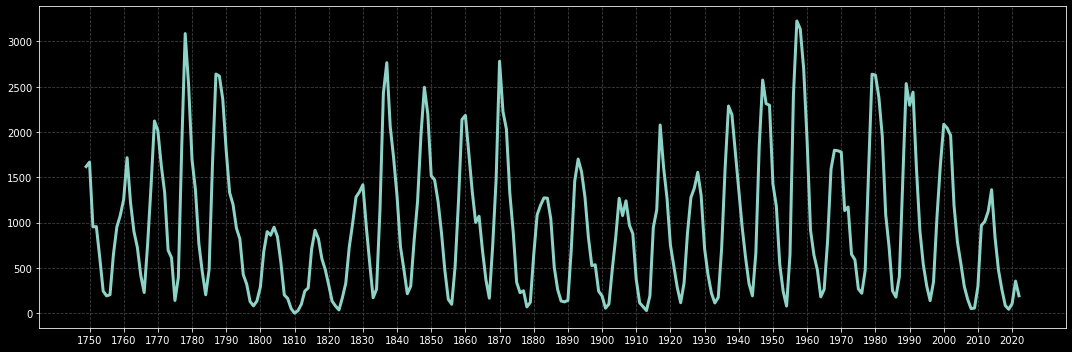

In [140]:
## just for fun, lets plot sunspots trending by year
plt.figure(figsize=(15, 5))
plt.plot(solar_cycle_df.index.values, solar_cycle_df["SUNSPOT_COUNT"])
plt.xticks(np.arange(1750, 2022, 10))
plt.show()


<br>

***

# <span style="color:#bce35b">Joining Datasets</span>

<!--  Copy/Past below !! Do not overwrite!!  -->
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<!-- <span style="color:#8c8c8c">Patrick Weatherford</span> -->

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

In [141]:
## creating list of datasets
dataset_list = [cancer_df, solar_time_df, solar_cycle_df]

# dataset_list[0]
# dataset_list[1]
# dataset_list[2]


<br>

***

# <span style="color:#bce35b">References</span>

<!--  Copy/Past below !! Do not overwrite!!  -->
<!-- # <span style="color:#bce35b;font-size:35px">Title<b>Title</b></span> -->
<!-- # <span style="color:#bce35b">H1</span> -->
<!-- ## <span style="color:#ae8bd5">H2</span> -->
<!-- ### <span style="color:#9c4957">H3</span> -->
<!-- #### <span style="color:white">H4</span> -->

<!-- <span style="color:#8c8c8c">Patrick Weatherford</span> -->

[Green]: <> (#bce35b)
[Purple]: <> (#ae8bd5)
[Coral]: <> (#9c4957)
[Grey]: <> (#8c8c8c)

<u>Cancer Death Rates</u><br>
Bahadir Umut Iscimen. (2019). Cancer Death Rates in the World 1990-2019. Kaggle.com. https://www.kaggle.com/datasets/bahadirumutiscimen/cancer-death-rates-in-the-world-19902019?select=total-cancer-deaths-by-type.csv


<br><u>Sunshine Duration by Country/City</u><br>
Wikipedia Contributors. (2022, March 14). List of cities by sunshine duration. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration


<br><u>Historical Solar Cycles</u><br>
Solar Cycle Progression | NOAA / NWS Space Weather Prediction Center. (2022). Noaa.gov. https://www.swpc.noaa.gov/products/solar-cycle-progression
